<a href="https://colab.research.google.com/github/MittalNeha/retinopathy-kaggle/blob/master/EfficientNet_multilabel_smallBatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import (Activation, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D,
                          Dense, BatchNormalization, GlobalAveragePooling2D)
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.losses import binary_crossentropy, categorical_crossentropy

from keras.applications.resnet50 import ResNet50
# from keras.applications.res

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from keras import metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils import class_weight, shuffle
import cv2
from keras import backend as K
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
def get_kaggle_data():
  os.environ['KAGGLE_USERNAME'] = "mittalneha"
  os.environ['KAGGLE_KEY'] = "59ec3f992f5fb4b510bebd8dea889381"
  
  !kaggle competitions download -c aptos2019-blindness-detection
  
  !mkdir kaggle-data
  !mv sample_submission.csv kaggle-data/
  !mv test.csv kaggle-data/

  !unzip test_images.zip -d kaggle-data/test_images

  !cp /content/gdrive/My\ Drive/Colab\ Notebooks/aug_train_images.zip .
  !cp /content/gdrive/My\ Drive/Colab\ Notebooks/aug_train.csv .
  
  !unzip aug_train_images.zip
  !mv aug_train_images kaggle-data/
  !mv aug_train.csv kaggle-data/
  
  !kaggle datasets download -d ratthachat/efficientnet-keras-weights-b0b5
  !cp /content/gdrive/My\ Drive/Colab\ Notebooks/efficientnet-master.zip .
  !unzip efficientnet-keras-weights-b0b5 -d kaggle-data/efficientnets-weights/
  !unzip efficientnet-master.zip
  

In [0]:
data_dir = "kaggle-data"
# get_kaggle_data()

In [0]:
# sys.path.remove('/content/efficientnet-master')

In [0]:
# !pip install efficientnet-master/

In [0]:
import sys
sys.path.append(os.path.abspath('efficientnet-master/'))
import efficientnet.keras as efn 

In [0]:
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 456
NUM_CLASSES = 5

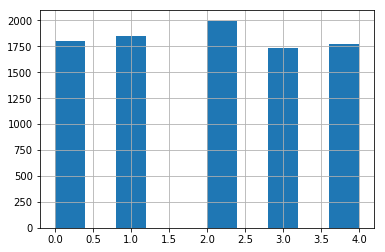

In [9]:
df_train = pd.read_csv('kaggle-data/aug_train.csv')
df_test = pd.read_csv('kaggle-data/test.csv')

df_train.columns = ['id_code', 'diagnosis']

x = df_train['id_code']
y = df_train['diagnosis']

# x, y = shuffle(x, y, random_state=8)
y.hist()


In [10]:
def get_label(diagnosis):
  return [i for i in range(diagnosis + 1)]
#     return ','.join([str(i+1) for i in range(diagnosis + 1)])
df_train['label'] = df_train.diagnosis.apply(get_label)
df_train.head()

,id_code,diagnosis,label
0,000c1434d8d7_0,2,"[0, 1, 2]"
1,001639a390f0,4,"[0, 1, 2, 3, 4]"
2,001639a390f0_0,4,"[0, 1, 2, 3, 4]"
3,001639a390f0_1,4,"[0, 1, 2, 3, 4]"
4,001639a390f0_2,4,"[0, 1, 2, 3, 4]"


In [0]:
mlb = MultiLabelBinarizer(classes=[0,1,2,3,4])
# labels = [(1,2), (1,), (1,2)]

# y = mlb.fit_transform(y)
# mlb.fit_transform(labels)
# mlb.fit_transform(list(y[i]) for i in range(0,len(y)))
# yy = mlb.fit_transform(df_train['diagnosis'])
# mlb.classes_

In [12]:
y = df_train['label']
y = mlb.fit_transform(y)
# y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(7785,)
(7785, 5)
(1374,)
(1374, 5)


In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ])
    ),
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Flipud(0.5)
],random_order=True)

In [0]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('kaggle-data/aug_train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('kaggle-data/aug_train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

The image Size is High, hence going OOM
- will use smaller match size
- Its recommended to use Group Normalization for smaller batch.

In [0]:
def create_model(input_shape, n_out, model_weights):
    input_tensor = Input(shape=input_shape)
    base_model = efn.EfficientNetB5(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('kaggle-data/efficientnets-weights/efficientnet-b5_imagenet_1000_notop.h5')
#     x = GlobalAveragePooling2D()(base_model.output)
    
    classifier = Sequential()
    classifier.add(GlobalAveragePooling2D())
#     classifier.add(Flatten())   
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(1024))
#     classifier.add(BatchNormalization())
    classifier.add(Activation('relu'))
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(n_out, activation='sigmoid', name='final_output'))
    #Use sigmoid for multilabel and softmax for single label classification
#     final_output = Dense(n_out, activation='sigmoid', name='final_output')(classifier.output)
    
    model = Sequential([
    base_model, 
    classifier
])
#     model = Model(input_tensor, final_output)
#     model.load_weights(model_weights)
    
    return model

In [16]:
!mkdir 'kaggle-data/model'

mkdir: cannot create directory ‘kaggle-data/model’: File exists


In [17]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 10; batch_size = 4
checkpoint = ModelCheckpoint('kaggle-data/model/EffNetB5-{epoch:02d}-{val_acc:.4f}.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# checkpoint = ModelCheckpoint('kaggle-data/model/xception-model.h5', verbose=1, monitor='val_acc',
#                               save_best_only=True, save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='kaggle-data/model/training_log.csv',
                       separator=',',
                       append=True)
# callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]

# train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=True, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='kaggle-data/efficientnets-weights/efficientnet-b5_imagenet_1000_notop.h5')

W0819 07:26:24.461827 140229918574464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 07:26:24.475222 140229918574464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 07:26:24.479549 140229918574464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0819 07:26:24.507781 140229918574464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 07:26:24.509047

In [0]:
for i, layer in enumerate(model.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=2, axis=-1, epsilon=0.1)

In [0]:
# reference link: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [0]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            
            def get_pred(y):
#                 print(y[0])
                y_pred = y > 0.5
#                 print(y_pred[0])
                y_pred = y_pred.astype(int).sum(axis=1) - 1
#                 print(y_pred.reshape(-1))
                return y_pred.reshape(-1)
                
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(get_pred(self.y_val),
                                      get_pred(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('kaggle-data/model/EffNet_qwk-{0:02d}-{1:.4f}.h5'.format(epoch, score))

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [21]:
train_y.shape

(7785, 5)

In [0]:
# train all layers
for layer in model.layers:
    layer.trainable = True

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy',
#              loss=kappa_loss,
            optimizer=Adam(lr=1e-3),
            metrics=['accuracy'])
#, metrics=['accuracy']
history = model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

W0819 07:27:01.570966 140229918574464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 07:27:01.582009 140229918574464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
1947/1947 [==============================] - 3243s 2s/step - loss: 0.3669 - acc: 0.6703 - val_loss: 0.3335 - val_acc: 0.8659

Epoch 00001: val_loss improved from inf to 0.33346, saving model to kaggle-data/model/EffNetB5-01-0.8659.h5
344/344 [==============================] - 127s 370ms/step

 epoch: 1 - QWK_score: 0.631984 

saving checkpoint:  0.6319843550020262
Epoch 2/10
1947/1947 [==============================] - 3194s 2s/step - loss: 0.3088 - acc: 0.6964 - val_loss: 0.2197 - val_acc: 0.9092

Epoch 00002: val_loss improved from 0.33346 to 0.21971, saving model to kaggle-data/model/EffNetB5-02-0.9092.h5
344/344 [==============================] - 122s 355ms/step

 epoch: 2 - QWK_score: 0.807103 

saving checkpoint:  0.8071033543131135
Epoch 3/10
1947/1947 [==============================] - 3195s 2s/step - loss: 0.2926 - acc: 0.7003 - val_loss: 0.1967 - val_acc: 0.9147

Epoch 00003: val_loss improved from 0.21971 to 0.19666, saving model to kaggle-data/model/EffNetB5-03-0

In [0]:
lr = K.get_value(model.optimizer.lr)
K.set_value(model.optimizer.lr, lr/2)

In [0]:
K.get_value(model.optimizer.lr)

0.00025

In [0]:
epochs = 30
history2 = model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    initial_epoch=15,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 16/30
487/487 [==============================] - 650s 1s/step - loss: 0.2328 - acc: 0.6776 - val_loss: 0.1423 - val_acc: 0.9479

Epoch 00016: val_loss improved from 0.14721 to 0.14234, saving model to kaggle-data/model/EffNetB5-16-0.9479.h5
86/86 [==============================] - 27s 312ms/step

 epoch: 16 - QWK_score: 0.910338 

saving checkpoint:  0.910338049556088
Epoch 17/30
487/487 [==============================] - 644s 1s/step - loss: 0.2193 - acc: 0.6795 - val_loss: 0.1318 - val_acc: 0.9504

Epoch 00017: val_loss improved from 0.14234 to 0.13183, saving model to kaggle-data/model/EffNetB5-17-0.9504.h5
86/86 [==============================] - 27s 313ms/step

 epoch: 17 - QWK_score: 0.914617 

saving checkpoint:  0.9146168718450581
Epoch 18/30
487/487 [==============================] - 645s 1s/step - loss: 0.2160 - acc: 0.6817 - val_loss: 0.1247 - val_acc: 0.9557

Epoch 00018: val_loss improved from 0.13183 to 0.12475, saving model to kaggle-data/model/EffNetB5-18-0.9557.h

KeyboardInterrupt: ignored

Load the best model

In [0]:
model.load_

# Evaluate Model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
all_scores = []
for i, name in tqdm(enumerate(valid_x)):
  path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
  image = cv2.imread(path)
  image = cv2.resize(image, (SIZE, SIZE))

  scores = model.evaluate((image[np.newaxis])/255, np.reshape(valid_y[i], (1,5)), verbose=0)
  all_scores.append(scores)

mean = np.mean(all_scores, axis=0)
sd = np.std(all_scores, axis=0)
print("Loss:    %.2f%% (+/- %.2f%%)" % (mean[0], sd[0]))
print("Accuracy:%.2f%% (+/- %.2f%%)" % (mean[1], sd[1]))

1374it [01:07, 20.22it/s]

Loss:    3.80% (+/- 3.01%)
Accuracy:1.00% (+/- 0.00%)


In [0]:
history2.history


NameError: ignored

In [0]:
def get_pred(y):
  y_pred = y > 0.5
  y_pred = y_pred.astype(int).sum(axis=1) - 1
  return y_pred.reshape(-1)

def check_model(hist, model):
  
  #Plot the curves
  N = len(hist.history['loss'])

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
  
 
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["acc"], label="train_acc")
  plt.plot(np.arange(0, N), hist.history["val_acc"], label="val_acc")
  plt.title("Training Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  
  plt.figure()
  plt.plot(np.arange(0, N), qwk.history, label="kappa_score")
  plt.title("Kappa score on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("kappa")
  plt.legend(loc="lower left")
  
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["lr"], label="learning_rate")
 
  plt.title("Learning Rate on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("LR")
  plt.legend(loc="lower left")
  
  
  #confusion matrix
  preds = []
  for i, name in tqdm(enumerate(valid_x)):
      path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
      image = cv2.imread(path)
  #     print(str(path))
      image = cv2.resize(image, (SIZE, SIZE))
      score_predict = model.predict((image[np.newaxis])/255)
      label_predict = get_pred(score_predict)
#       print('Predict {}-->{}'.format(score_predict, label_predict))
#       label_predict = np.argmax(score_predict)
      
      preds.append(label_predict)

#   valid_labels = np.argmax(valid_y, axis=-1)
  valid_labels = get_pred(valid_y)
  
  cm  = confusion_matrix(valid_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
  plt.show()

1374it [01:30, 15.14it/s]


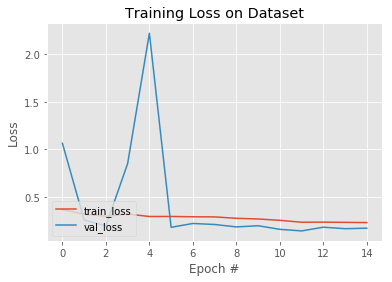

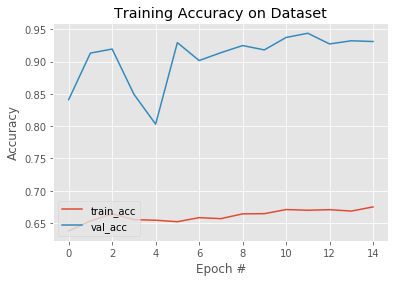

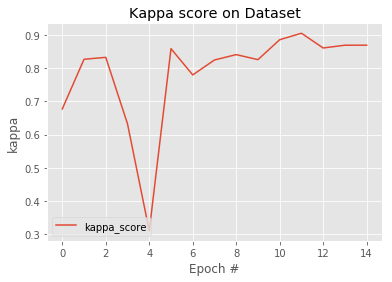

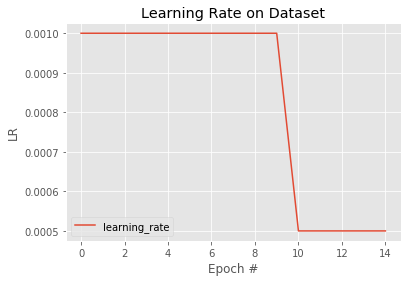

<Figure size 432x288 with 0 Axes>

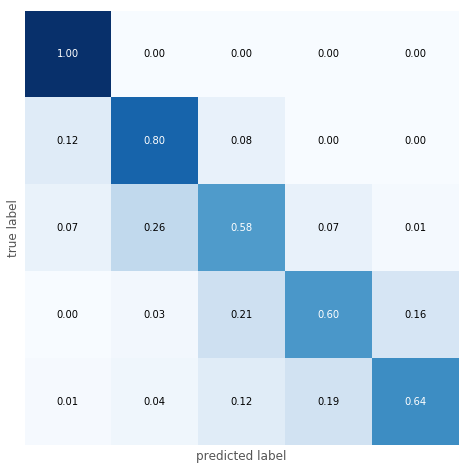

In [0]:
check_model(history, model)

In [0]:
  def get_pred(y):
    y_pred = y > 0.5
    mask = y_pred == 0
    return np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

  preds = []
  for i, name in tqdm(enumerate(valid_x)):
      path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
      image = cv2.imread(path)
  #     print(str(path))
      image = cv2.resize(image, (SIZE, SIZE))
      score_predict = model.predict((image[np.newaxis])/255)
      label_predict = get_pred(score_predict)
#       print('Predict {}-->{}'.format(score_predict, label_predict))
#       label_predict = np.argmax(score_predict)
      
      preds.append(label_predict)

#   valid_labels = np.argmax(valid_y, axis=-1)
  valid_labels = get_pred(valid_y)
  
  cm  = confusion_matrix(valid_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
  plt.show()

In [0]:
qwk.history

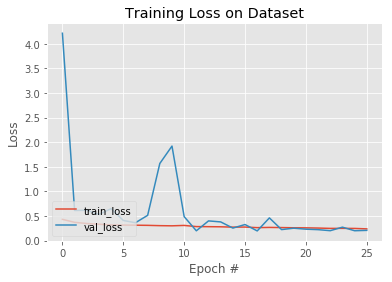

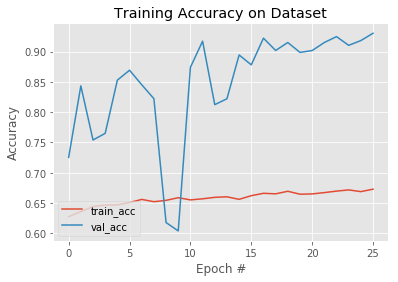

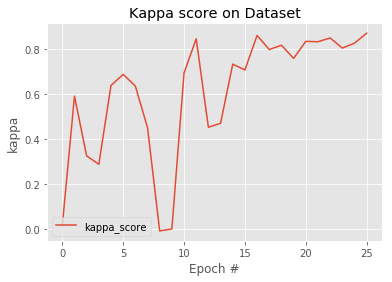

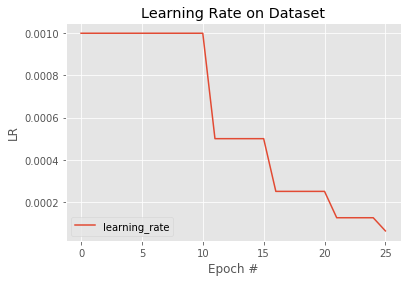

In [0]:
check_model(history, model)

1374it [01:07, 20.37it/s]


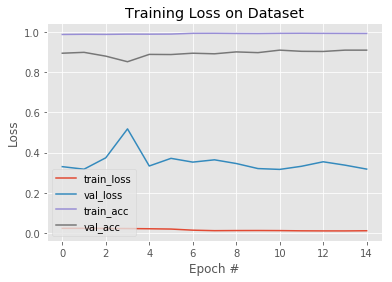

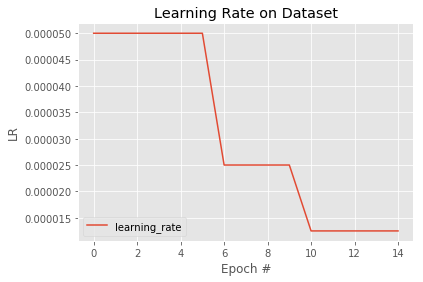

<Figure size 432x288 with 0 Axes>

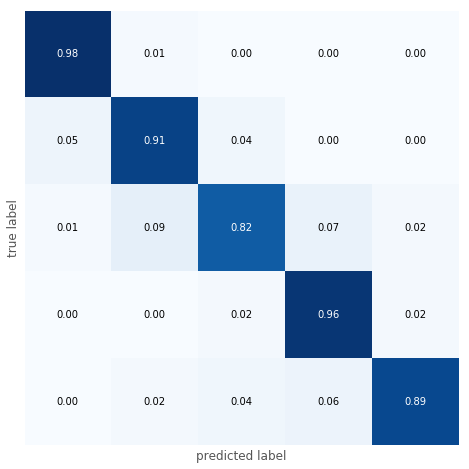

In [0]:
check_model(history2, model)

# Save Model

In [0]:
%cd kaggle-data/model

/content/kaggle-data/model


In [0]:
!zip EffNet_multi2.zip EffNet_qwk-25-0.9440.h5
!cp EffNet_multi2.zip /content/gdrive/My\ Drive/Colab\ Notebooks/

  adding: EffNet_qwk-25-0.9440.h5 (deflated 7%)


In [0]:
%cd ../../

/content


# Compare models

In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/resnet50_aug3.zip .
!mkdir resnet50_aug3
!unzip resnet50_aug3.zip -d resnet50_aug3

Archive:  resnet50_aug3.zip
  inflating: resnet50_aug3/Resnet50-09-0.8952.h5  
  inflating: resnet50_aug3/Resnet50_qwk-23-0.9533.h5  


In [0]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/resnet50_aug4.zip .
!mkdir resnet50_aug4
!unzip resnet50_aug4.zip -d resnet50_aug4

Archive:  resnet50_aug4.zip
  inflating: resnet50_aug4/Resnet50_qwk-29-0.9558.h5  


In [0]:
def preprocess_image(img):
  
  if img.shape[2] ==1:
    img = np.dstack([img, img, img])

  img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret, img2 = cv2.threshold(img1, 10, 255, cv2.THRESH_BINARY)
  points = np.argwhere(img2!=0)
  points = np.fliplr(points)
  x, y, w, h = cv2.boundingRect(points)

  color_cropped = img[y:y+h, x:x+w]

  clahe = cv2.createCLAHE(clipLimit=4.0)

  lab = cv2.cvtColor(color_cropped, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab_planes[1] = clahe.apply(lab_planes[1])
  lab_planes[2] = clahe.apply(lab_planes[2])
  
  out = cv2.merge(lab_planes)
  img3 = cv2.cvtColor(out, cv2.COLOR_LAB2BGR)
  
  img = cv2.resize(img3, (SIZE,SIZE), cv2.INTER_AREA)
  
#   img = img.astype(np.float32)/255
  
  return img

In [0]:
train, val = train_test_split(df_train, test_size=0.4)
train_data = train

In [0]:
train.head()

,id_code,diagnosis
7906,d9e58e4d8689,0
5884,a2ddabee14e9,4
191,05a5183c92d0_0,1
7120,c3cd0200df79_1,3
7202,c613db1cab27,2


In [0]:
model1 = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights="resnet50_aug3/Resnet50-09-0.8952.h5")
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(1e-3))

model2 = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES,
    model_weights='resnet50_aug4/Resnet50_qwk-29-0.9558.h5')
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(1e-3))

W0807 06:26:48.074534 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 06:26:48.142511 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 06:26:48.170713 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0807 06:26:48.221229 139889221781376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 06:26:48.222414

In [0]:
#Evaluate with train data itself
train_img = []
train_labels = []

for idx, row in train_data.iterrows():
    path = 'kaggle-data/aug_train_images/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = preprocess_image(img)

    label = to_categorical(int(row['diagnosis']), num_classes=5)
    train_img.append(img)
    train_labels.append(label)
    
train_img = np.array(train_img)
train_labels = np.array(train_labels)

## Evaluate First Model

In [0]:
eval_loss1, eval_score1 = model1.evaluate(train_img, train_labels, batch_size=16)
print("Loss on test set: ", eval_loss1)
print("Accuracy on test set: ", eval_score1)

5495/5495 [==============================] - 96s 18ms/step
Loss on test set:  7.650551852624561
Accuracy on test set:  0.2043676069316482


In [0]:
#Evaluate with train data itself
predicted1 = []
# train_labels = []

for idx, row in train_data.iterrows():
    path = 'kaggle-data/aug_train_images/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = preprocess_image(img)

    label = to_categorical(int(row['diagnosis']), num_classes=5)
    score_predict = model1.predict((img[np.newaxis])/255)
    label_predict = np.argmax(score_predict)
    predicted1.append(str(label_predict))
    

In [0]:
cm  = confusion_matrix(orig_train_labels, predicted1)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()

ValueError: ignored

In [0]:
preds1 = model1.predict(train_img, batch_size=16)
preds1 = np.argmax(preds1, axis=-1)

# Original labels
orig_train_labels = np.argmax(train_labels, axis=-1)

## Confusion Matrix

<Figure size 432x288 with 0 Axes>

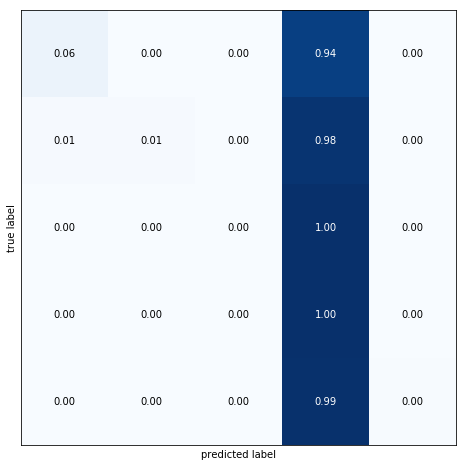

In [0]:
cm  = confusion_matrix(orig_train_labels, preds1)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()

## Evaluate second Model

In [0]:
eval_loss2, eval_score2 = model2.evaluate(train_img, train_labels, batch_size=16)
print("Loss on test set: ", eval_loss2)
print("Accuracy on test set: ", eval_score2)

5495/5495 [==============================] - 91s 17ms/step
Loss on test set:  7.940974250460235
Accuracy on test set:  0.26223839856040165


In [0]:
preds2 = model2.predict(train_img, batch_size=16)
preds2 = np.argmax(preds2, axis=-1)

# Original labels
# orig_train_labels = np.argmax(train_labels, axis=-1)

<Figure size 432x288 with 0 Axes>

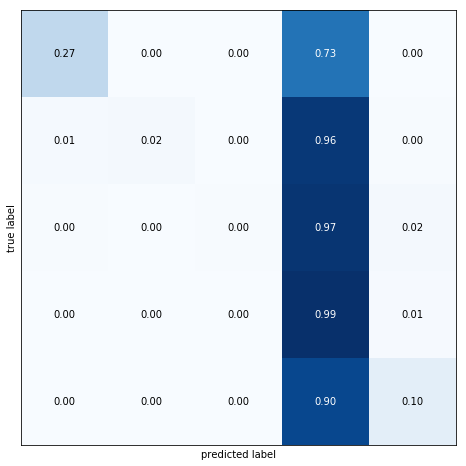

In [0]:
cm  = confusion_matrix(orig_train_labels, preds2)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()